In [2]:
import mlflow
import mlflow.tensorflow
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

from SpectraVAE import SpectraVAE
from BandPassVAE import BandPassVAE
from ParamVAE import ParamVAE
from ParamVAEapply import ParamVAEapply
fig_path = "/data/kirg/MMVAE/MLFlow"
weight_path = "/data/kirg/MMVAE/"


In [3]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23535157248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1398852750107389689
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



I0000 00:00:1751127801.014610   40977 gpu_device.cc:2019] Created device /device:GPU:0 with 22444 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
mlflow.set_tracking_uri("file:/data/kirg/MMVAE/MLFlow/mlruns")

mlflow.set_experiment("mmvae_pegase")

mlflow.start_run(nested=True)

beta = 1e-4
epochs = 50
latent_dim = 32
batch_size = 256

mlflow.log_param("beta", beta)
mlflow.log_param("epochs", epochs)
mlflow.log_param("latent_dim", latent_dim)



32

In [5]:
from gen_dataset import *
from filters import filter_data, filters

filer_names = [name for name, _ in filters]

reader = SpectrumReader('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
lages, lmets, flx, wl = reader.read()

# Setup interpolator and processor
interpolator = SpectrumInterpolator(lages, lmets, flx)
processor = SpectrumProcessor(interpolator)

# Setup photometric calculator with filters
photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)

# Create DatasetBuilder with processor, wavelength grid and photocalc
builder = DatasetBuilder(processor, wl, photocalc)

# Generate dataset (already includes photometry and augmentation)
integrals, params, spectra = builder.generate(n_samples=32000, age_range=(10, 15000),
                                              young_age_range=(10, 3000),
                                              young_age_threshold=4000,
                                              old_blend_prob=0.0,
                                              young_extinction_prob=0.0, 
                                              eml_prob=0.0, 
                                              n_processes=8)

perm = np.random.permutation(len(integrals))

# Apply the same permutation to all three
integrals_shuffled = integrals[perm]
params_shuffled = params[perm]
spectra_shuffled = spectra[perm]

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
spectra /= np.max(spectra, axis=1)[:, None]


In [6]:
'''
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()
'''

'\nii=1000\nfor ii in np.arange(ii, ii+10):\n    fig, axs = plt.subplots(1, 2)\n    fig.set_size_inches(12, 5)\n    axs[1].plot(spectra[ii], label="true spectrum")\n    axs[1].set_xlabel(\'Wavelength, A\')\n    axs[0].bar(filer_names, integrals[ii])\n    axs[0].set_ylabel(\'Renormalized band flux\')\n    print(params[ii])\n    fig.suptitle(\'z = %.2f\' % (params[ii, 0]))\n    plt.legend()\n    plt.show()\n'

In [10]:
save_path = os.path.join(weight_path, 'epochs/SpectraVAE/')
os.makedirs(save_path, exist_ok=True)


spvae = SpectraVAE(100, latent_dim, beta=beta)
spvae.compile(optimizer=keras.optimizers.Adam())

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

spvae(tf.zeros((1, 100)))


hsp=spvae.fit(spectra, epochs=epochs, batch_size=batch_size, validation_split=0.2,
              callbacks=[checkpoint_cb])

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


Epoch 1/50


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(256, 100))
  warnings.warn(msg)


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 69.3102 - loss: 0.0619 - reconstruction_loss: 0.0550
Epoch 1: saving model to /data/kirg/MMVAE/epochs/SpectraVAE/weights_epoch_01.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - kl_loss: 69.2899 - loss: 0.0619 - reconstruction_loss: 0.0549 - val_kl_loss: 54.0570 - val_loss: 0.0208 - val_reconstruction_loss: 0.0154
Epoch 2/50
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 47.5167 - loss: 0.0150 - reconstruction_loss: 0.0102
Epoch 2: saving model to /data/kirg/MMVAE/epochs/SpectraVAE/weights_epoch_02.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 47.4780 - loss: 0.0150 - reconstruction_loss: 0.0102 - val_kl_loss: 39.6899 - val_loss: 0.0160 - val_reconstruction_loss: 0.0120
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 32.3653 - loss: 0.0115 - reconstruction_loss: 0.0083
Epoch 3: saving model to /data/kirg/MMVAE/epochs/SpectraVAE/weights_epoch_03.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━

In [ ]:
'''
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()
'''

In [11]:
save_path = os.path.join(weight_path, 'epochs/BandPassVAE/')
os.makedirs(save_path, exist_ok=True)


bpvae = BandPassVAE(5,latent_dim, spvae, beta=beta)
bpvae.compile(optimizer=keras.optimizers.Adam())

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

bpvae(tf.zeros((1, 5)))


h=bpvae.fit((integrals, spectra), epochs=epochs, batch_size=batch_size, validation_split=0.2,
            callbacks=[checkpoint_cb])


Epoch 1/50


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(256, 5))
  warnings.warn(msg)
2025-06-28 18:40:53.074468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 4 bytes spill stores, 4 bytes spill loads



1977/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 11.5975 - loss: 0.3495 - reconstruction_loss: 0.3484((<tf.Tensor 'data:0' shape=(256, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(256, 100) dtype=float32>),)

Epoch 1: saving model to /data/kirg/MMVAE/epochs/BandPassVAE/weights_epoch_01.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_loss: 11.6060 - loss: 0.3458 - reconstruction_loss: 0.3446 - val_kl_loss: 11.9456 - val_loss: 0.0596 - val_reconstruction_loss: 0.0584
Epoch 2/50
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 11.6667 - loss: 0.0352 - reconstruction_loss: 0.0340
Epoch 2: saving model to /data/kirg/MMVAE/epochs/BandPassVAE/weights_epoch_02.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 11.6663 - loss: 0.0352 - reconstruction_loss: 0.0340 - val_kl_loss: 11.4901 - val_loss: 0.0579 - val_reconstruction_loss: 0.0568
Epoch 3/50
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 11.3556 - loss: 0.0331 - reconstruction_loss: 0.0319
Epo

In [12]:
'''
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()
'''

'\nii=10126\nfor ii in np.arange(ii, ii+10):\n    fig, axs = plt.subplots(1, 2)\n    fig.set_size_inches(12, 5)\n    axs[1].plot(spectra[ii], label="true spectrum")\n    s = bpvae(np.reshape(integrals[ii], (1,5)))\n    s = np.reshape(s[0].numpy(),(100,))\n    axs[1].plot(s, label="spectrum from bandpasses")\n    axs[1].set_xlabel(\'Wavelength, A\')\n    axs[0].bar(filer_names, integrals[ii])\n    axs[0].set_ylabel(\'Renormalized band flux\')\n    fig.suptitle(\'z = %.2f\' % (params[ii, 0]))\n    plt.legend()\n    plt.show()\n'

In [13]:
save_path = os.path.join(weight_path, 'epochs/ParamVAE/')
os.makedirs(save_path, exist_ok=True)

parvae = ParamVAE(100, latent_dim, spvae, beta=beta)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

parvae(tf.zeros((1, 100)))


parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((spectra, params), epochs=epochs, batch_size=batch_size, validation_split=0.2,
             callbacks=[checkpoint_cb])

Epoch 1/50


2025-06-28 18:46:29.372204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_950', 8 bytes spill stores, 8 bytes spill loads



1963/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - kl_loss: 10.2803 - loss: 0.0040 - reconstruction_loss: 0.0030((<tf.Tensor 'data:0' shape=(256, 100) dtype=float32>, <tf.Tensor 'data_1:0' shape=(256, 3) dtype=float32>),)

Epoch 1: saving model to /data/kirg/MMVAE/epochs/ParamVAE/weights_epoch_01.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 10.2806 - loss: 0.0040 - reconstruction_loss: 0.0030 - val_kl_loss: 10.4048 - val_loss: 0.0032 - val_reconstruction_loss: 0.0022
Epoch 2/50
1959/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 10.2805 - loss: 0.0026 - reconstruction_loss: 0.0016
Epoch 2: saving model to /data/kirg/MMVAE/epochs/ParamVAE/weights_epoch_02.weights.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - kl_loss: 10.2806 - loss: 0.0026 - reconstruction_loss: 0.0016 - val_kl_loss: 10.4048 - val_loss: 0.0022 - val_reconstruction_loss: 0.0012
Epoch 3/50
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 10.2804 - loss: 0.0025 - reconstruction_loss: 0.0014
Epoch 3

In [14]:
parvaeapply = ParamVAEapply(5,latent_dim, bpvae, parvae, beta=beta)

tf.Tensor([ 0.3912536   0.29543912 -0.2474122 ], shape=(3,), dtype=float32) [ 0.44878871  0.27040504 -0.4974133 ]


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/2693343724.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(80000, 5))
  warnings.warn(msg)


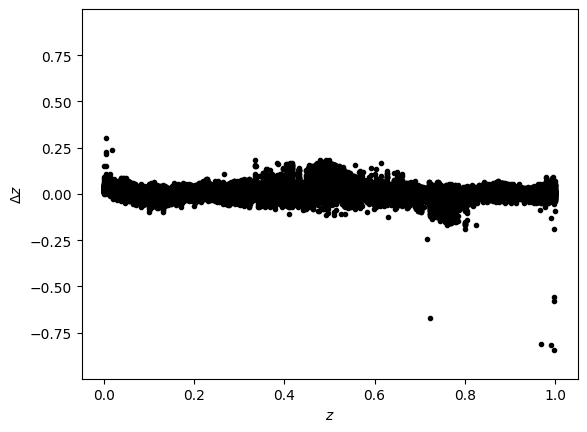

In [15]:
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/325034530.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


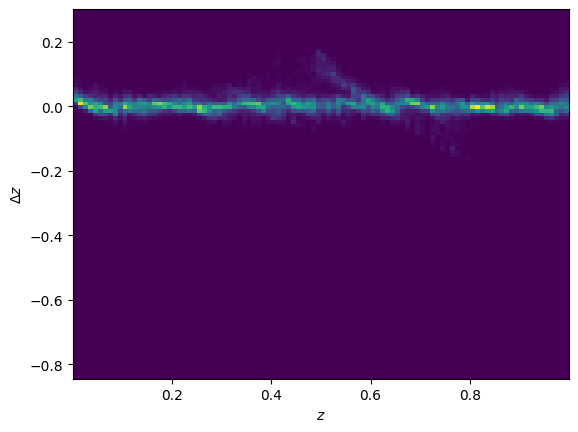

In [16]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

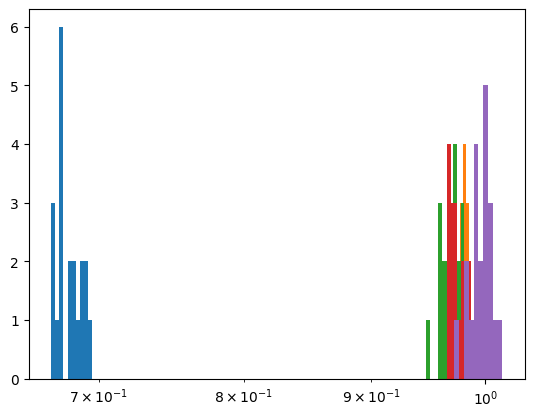

In [17]:
idx_sel = np.where(params[:,0] == params[200000, 0])[0]

for i in range(0, 5):
    plt.hist(integrals[idx_sel][:,i])

plt.xscale('log')
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/582374311.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_40977/582374311.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


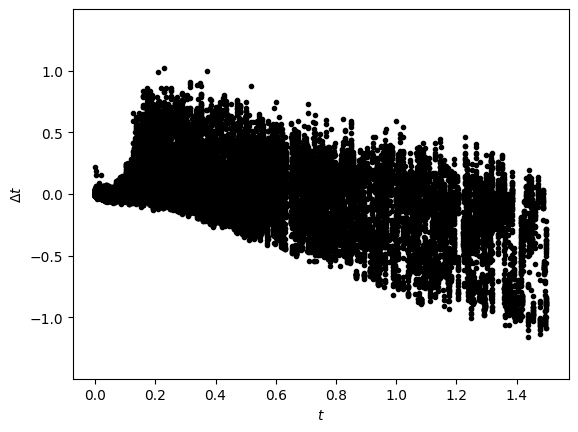

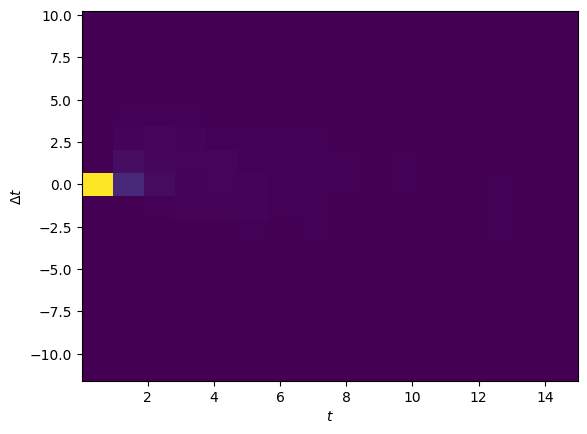

In [18]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/1447751827.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_40977/1447751827.py:11: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])


['z', 'zerr', 'chi2', 'mean_fiber_ra', 'mean_fiber_dec', 'id', 'targetphotid', 'targetid', 'tileid', 'zwarn', 'object_id', 'ra', 'dec', 'g_kronflux_mag', 'g_kronflux_magerr', 'r_kronflux_mag', 'r_kronflux_magerr', 'i_kronflux_mag', 'i_kronflux_magerr', 'z_kronflux_mag', 'z_kronflux_magerr', 'y_kronflux_mag', 'y_kronflux_magerr', 'Separation']
tf.Tensor([nan nan nan], shape=(3,), dtype=float32) 0.8578496837263326
[np.float64(0.8578496837263326), np.float64(0.2904546610270198), np.float64(0.7854575867277388), np.float64(0.822681493570212), np.float64(0.7853066054030228), np.float64(0.7895841837901794), np.float64(0.8548200914797005), np.float64(0.8158084245673792), np.float64(0.45061105141443), np.float64(0.3666860000698166)]


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(129135, 5))
  warnings.warn(msg)


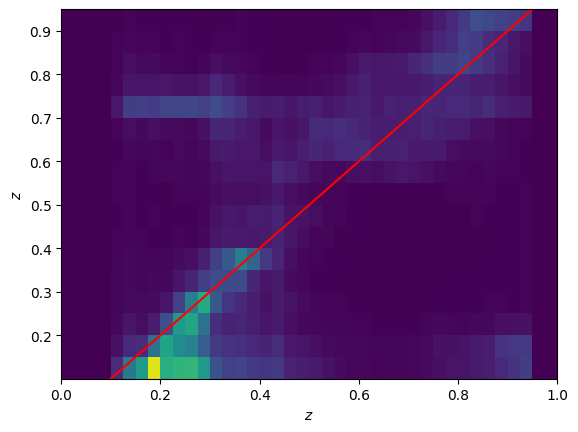

In [19]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

print(t_hsc.colnames)

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]

print(plx[:10])

plt.hist2d(plx, ply, range=[[0, 1], [-1, 1]], bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
filename = f"plot_dz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], range=[[0, 1], [-1, 1]], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
filename = f"plot_zz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

t_hsc['z_photo'] = s[:, 0]



<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/170014217.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


tf.Tensor([ 0.8889045   0.03212789 -0.03101593], shape=(3,), dtype=float32) 0.822681493570212


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(119174, 5))
  warnings.warn(msg)


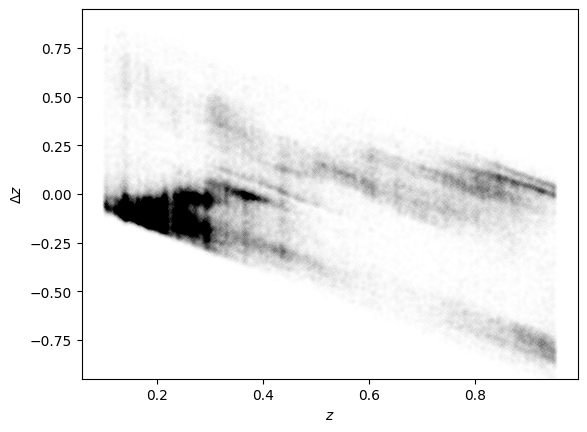

In [20]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0) &
                (t_hsc_['g_kronflux_mag'] > 0) &
                (t_hsc_['r_kronflux_mag'] > 0) &
                (t_hsc_['i_kronflux_mag'] > 0) &
                (t_hsc_['z_kronflux_mag'] > 0) &
                (t_hsc_['y_kronflux_mag'] > 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p
print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
t_hsc['z_photo'] = s[:, 0]

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:56: SyntaxWarning: invalid escape sequence '\D'
<>:63: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:56: SyntaxWarning: invalid escape sequence '\D'
<>:63: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_40977/3463410153.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$ (median subtracted)')
/tmp/ipykernel_40977/3463410153.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_40977/3463410153.py:56: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_40977/3463410153.py:63: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


[0.82268149 0.78530661 0.78958418 ... 0.16614557 0.36798173 0.15478596]


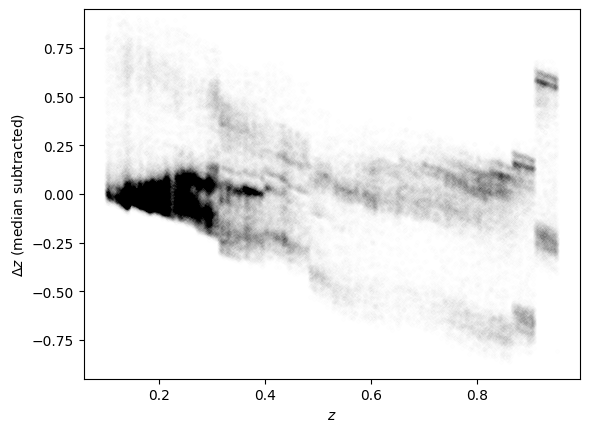

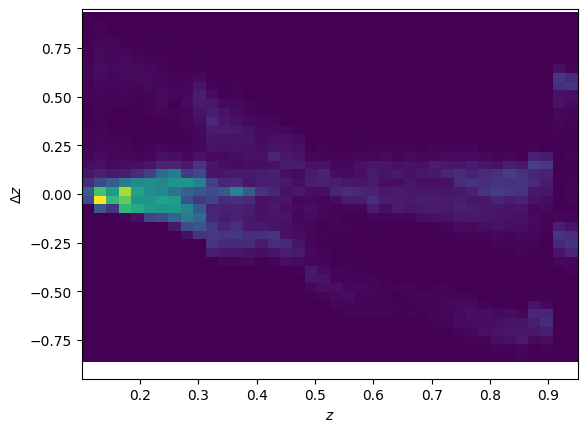

0.1289551041626161 -0.011524759
0.16675357122760023 -0.009413704
0.20549661316292753 -0.009218603
0.24902531553465013 -0.008331582
0.2907676168878376 -0.034141786
0.3324651996521629 -0.0011387467
0.374438281179219 -0.0016434789
0.41987729397059353 -0.0046081096
0.45863532727414563 -0.0033615828
0.5031221036710283 0.0
0.5464428117563161 0.02473855
0.5907527101185891 0.015755564
0.6316076398930258 0.016974658
0.6735571412594913 0.018345445
0.7168747568173149 0.028183281
0.7594628511381076 0.041134506
0.8020151778761043 0.026987016
0.8432651477960741 0.04982111
0.8855367611330498 0.0
0.9288160434709226 0.0


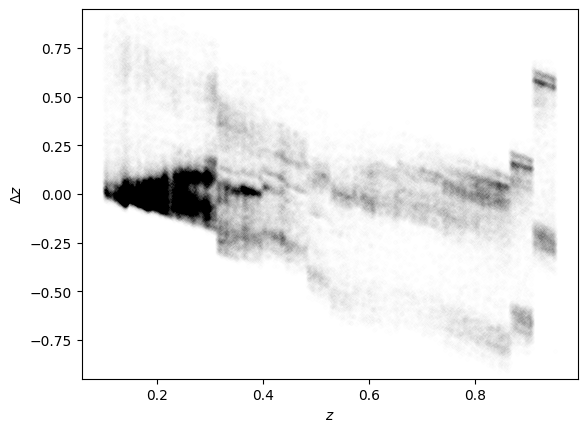

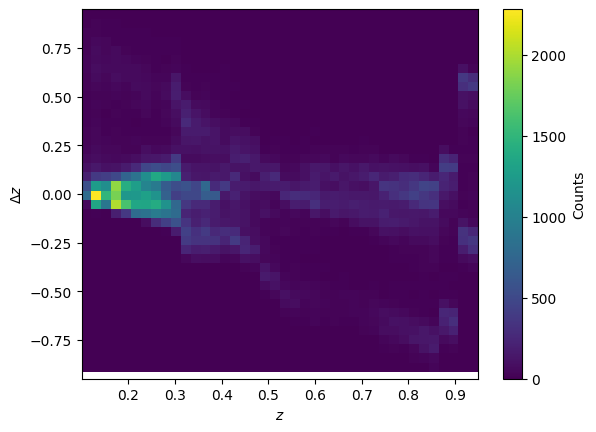

In [21]:
plx = np.array(p[:])
ply = np.array(res[:])
print(plx)
# Set number of bins
N = 20  # You can change this to whatever number of bins you want

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract median ply in each bin
corrected_ply = ply
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        median_val = np.median(ply[bin_mask])
        corrected_ply[bin_mask] -= median_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$ (median subtracted)')
plt.show()

plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


from astropy.stats import sigma_clip


N = 20

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        clipped = sigma_clip(ply[bin_mask], sigma=2.5, maxiters=20)
        mean_val = np.median(clipped.data[~clipped.mask])
        print(np.mean(plx[bin_mask]), mean_val)
        corrected_ply[bin_mask] -= mean_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

# 2D histogram
plt.hist2d(plx, corrected_ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.colorbar(label='Counts')
plt.show()


34.646902022999356 -1.4101822701929754
[20.771496 19.499832 18.983864 18.680294 18.475664] [0.00637912 0.00253034 0.00162245 0.00221111 0.00382917]
[ 0.27181267  0.20160774 -0.48025641]


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


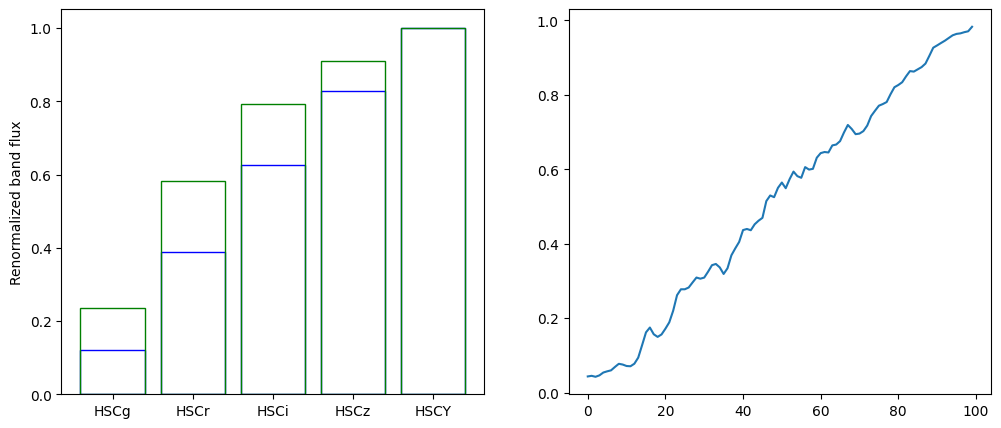

(<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-2.60978043e-02, -3.28173675e-02, -2.42595635e-02,
         1.99850500e-02,  4.42827456e-02, -1.64041078e+00,
        -1.29071623e-02,  3.76166850e-02, -1.58441253e-02,
         5.40151477e-01, -1.29553936e-02, -5.05306199e-02,
         1.87505409e-03,  1.93993598e-02,  3.62286419e-02,
        -1.75823793e-02,  2.11801678e-02, -5.01700521e-01,
        -1.86886787e-02, -2.30034776e-02, -1.18077844e-02,
         9.12167132e-03,  5.77304512e-04, -7.98963755e-03,
        -1.09101385e-02,  1.30198523e-03,  5.79887629e-03,
         2.21161246e-02,  1.07120499e-02,  7.39841163e-03,
        -6.04766607e-03, -1.55338012e-02]], dtype=float32)>, <tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-9.92445275e-03,  6.48933277e-03, -3.03508285e-02,
        -8.89031775e-03, -8.32724720e-02, -5.25790834e+00,
        -2.91177202e-02, -1.86985433e-02, -4.52305377e-03,
        -7.35222054e+00, -5.91314584e-03, -2.19602957e-02,
        -3.823

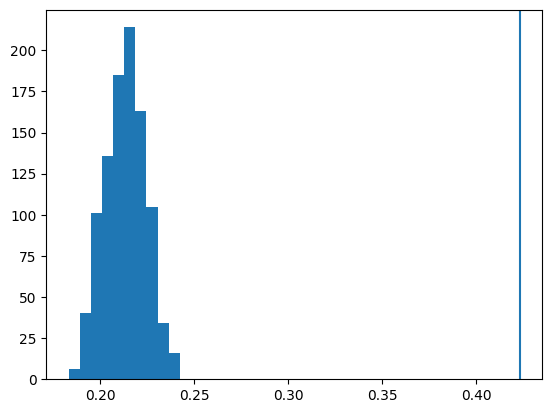

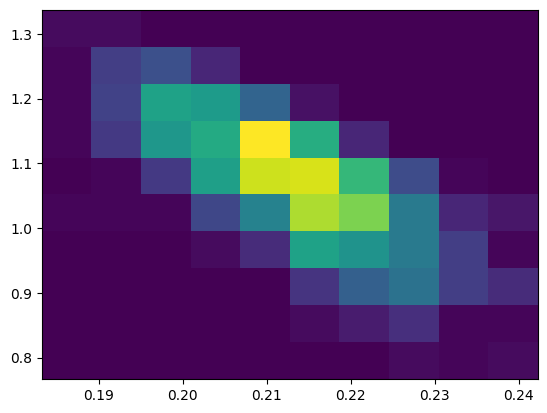

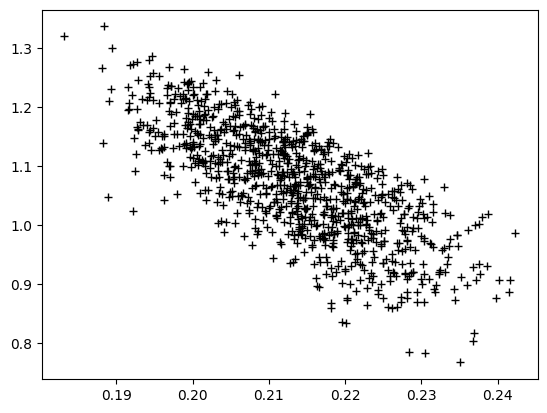

In [22]:
r = t_hsc[t_hsc['targetid'] == 39627749068903312][0]

ii = 50500

print(r['ra'], r['dec'])

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
mags_err = np.array([r['g_kronflux_magerr'], r['r_kronflux_magerr'], r['i_kronflux_magerr'], r['z_kronflux_magerr'], r['y_kronflux_magerr']])

print(mags, mags_err)

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
#plt.legend()
plt.show()

p_ls = parvaeapply.apply(np.reshape(bandfl, (1,5)))


p = parvaeapply(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvaeapply(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.axvline(r['z'])

plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

RA, Dec: 35.349727676882964 1.7417466027924386
Input Magnitudes: [19.97831  19.457182 19.020638 18.94626  18.81935 ]
Magnitude Errors: [0.00189602 0.00180373 0.0013963  0.00258375 0.00410256]


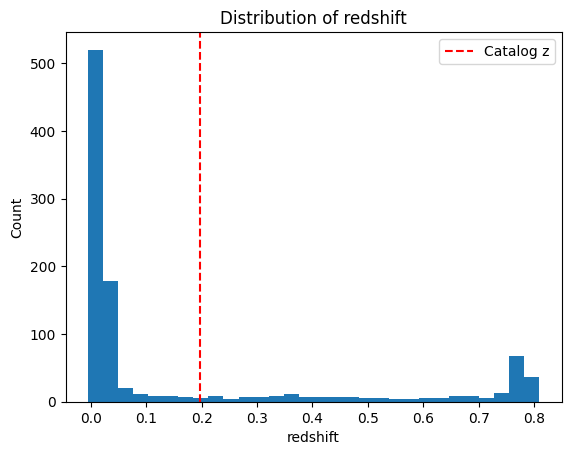

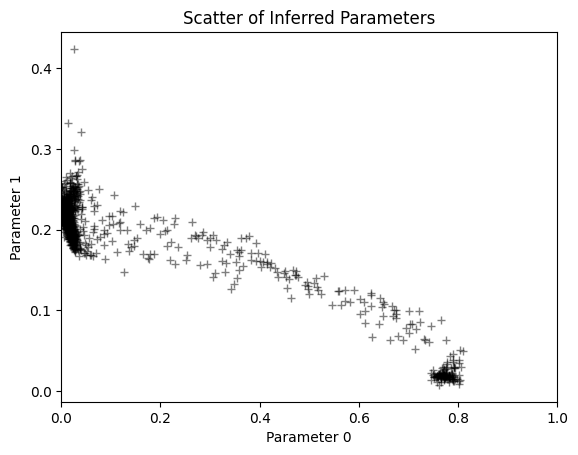

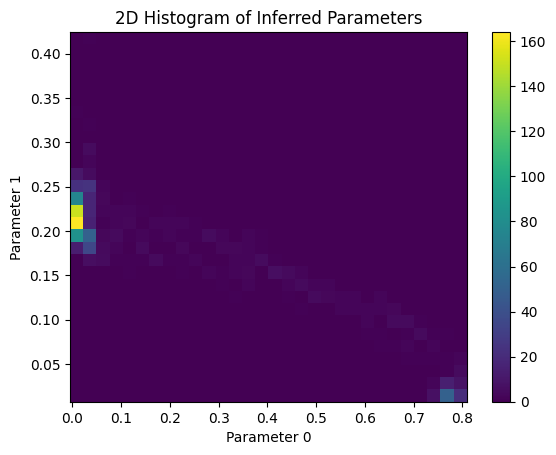

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
target_id = 39627827598855683
nsmpl_lat = 1000

# Extract data for target
r = t_hsc[t_hsc['targetid'] == target_id][0]
print("RA, Dec:", r['ra'], r['dec'])

# Extract magnitudes and errors
mag_keys = ['g_kronflux_mag', 'r_kronflux_mag', 'i_kronflux_mag', 'z_kronflux_mag', 'y_kronflux_mag']
magerr_keys = [k + 'err' for k in mag_keys]

mags = np.array([r[k] for k in mag_keys])
mags_err = np.array([r[k] for k in magerr_keys])

print("Input Magnitudes:", mags)
print("Magnitude Errors:", mags_err)

# Sample different magnitudes
mag_samples = np.random.normal(loc=mags, scale=mags_err, size=(nsmpl_lat, len(mags)))

# Convert magnitudes to normalized fluxes
bandfl_samples = 10**(-0.4 * mag_samples)
bandfl_samples /= np.max(bandfl_samples, axis=1)[:, None]  # normalize per sample

# Apply parvae to each sample
param_evals = []
for i in range(nsmpl_lat):
    band_input = np.reshape(bandfl_samples[i], (1, -1))
    p = parvaeapply(band_input)
    param_evals.append(p[0].numpy())

param_evals = np.array(param_evals)

# Plot: 1D Histogram of First Parameter (e.g., redshift)
plt.hist(param_evals[:, 0], bins=30)
plt.axvline(r['z'], color='r', linestyle='--', label='Catalog z')
plt.xlabel("redshift")
plt.ylabel("Count")
plt.title("Distribution of redshift")
plt.legend()
plt.show()

# Plot: 2D Scatter of First Two Parameters
plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("Scatter of Inferred Parameters")
plt.show()

# Plot: 2D Histogram
plt.hist2d(param_evals[:, 0], param_evals[:, 1], bins=30)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("2D Histogram of Inferred Parameters")
plt.colorbar()
plt.show()

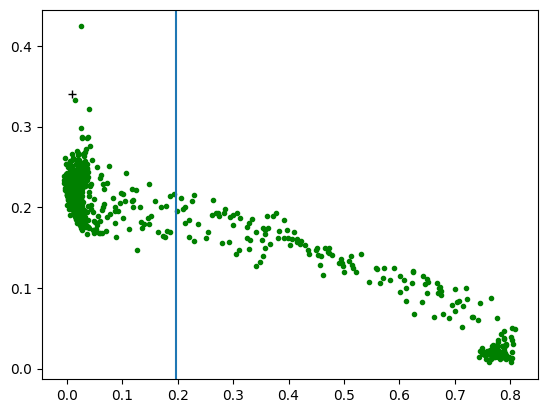

In [24]:
mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.022**2)[0]

p_v = params[idx]

plt.plot(param_evals[:, 0], param_evals[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(r['z'])
#plt.axhline(r['ssp_age']/1e4)

plt.show()

[5700 5700 5700 5701 5701 5701 5702 5702 5702 5703 5703 5703 5704 5704
 5704 5705 5705 5705 5706 5706 5706 5707 5707 5707 5708 5708 5708 5709
 5709 5709 5710 5710 5710 5711 5711 5711 5712 5712 5712 5713 5713 5713
 5714 5714 5714 5715 5715 5715 5716 5716 5716 5717 5717 5717 5718 5718
 5718 5719 5719 5719]
[ 0.50868317  0.04136965 -0.26702098]


NameError: name 'parvaeuse' is not defined

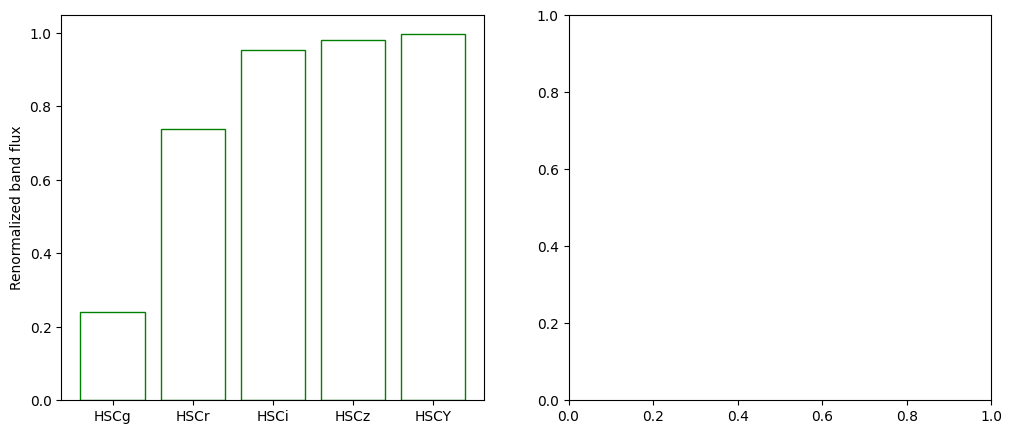

In [25]:
ii = 5700

bandfl = integrals[ii]

idx_same_smpl = np.where(params == params[ii])[0]
print(idx_same_smpl)


nsmpl = 10
p_est = []
for idx_sm_ in idx_same_smpl:
    for i in range(nsmpl):
        p_estls = parvaeapply(np.reshape(integrals[idx_sm_], (1,5)))
        p_est.append(p_estls[0].numpy())

p_est = np.array(p_est)

p0 = params[ii]

print(p0)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')

s = parvaeuse(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
plt.show()




rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.006**2)[0]


p_v = params[idx]

plt.plot(p_est[:, 0], p_est[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(p0[0])
plt.axhline(p0[1])

plt.show()

